# Load Files in Directory

Prior to running any analysis open gitbash and remove headers from the .asc data file exported by HEKA by running the following lines of code within the folder containing the data.

```
1. for file in {.*,*}; do sed -i '/Series/d' "$file";done
2. for file in {.*,*}; do sed -i '/Sweep/d' "$file";done
3. for file in {.*,*}; do sed -i '/Index/d' "$file";done
4. for file in {.*,*}; do sed -i '/s\*$/d' "$file";done
```
Next, run the below codeblock to change the working directory to the folder containing the data to be analyzed and create a list of all .asc files within the folder.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from matplotlib import gridspec
import matplotlib.lines as mlines

file_list=[]
os.chdir('C:/Users/mny3/Desktop/Mike Young Data/flna_data/180720_mp1flna_poke')
file_list += [file for file in os.listdir() if file.endswith('asc')]

# Pressure Clamp Analysis

## Representative Trace

The below code will create a plot of the representative traces aligned to the stimulus trace. The traces are baseline subtracted based on the mean current during the 5s prepulse from 1000 ms < t < 4900 ms. For visualization purposes only the subset of the trace after stimulus onset (t=5000 ms) is shown. If you would like to visualize the entire trace including the prepulse set the variable whole_trace to True. The red dotted line in the trace indicates 0 pA.

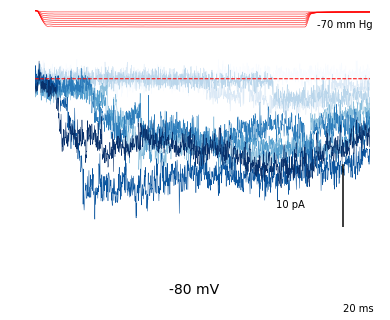

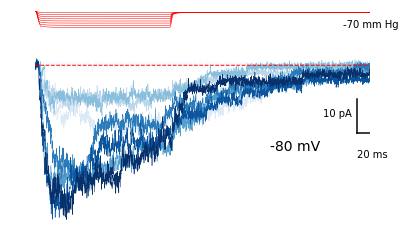

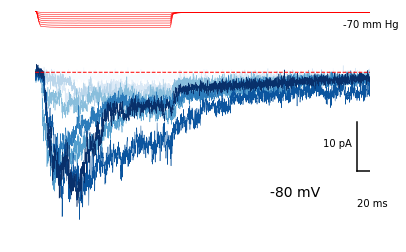

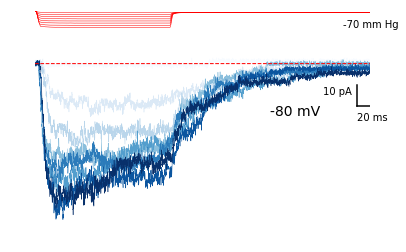

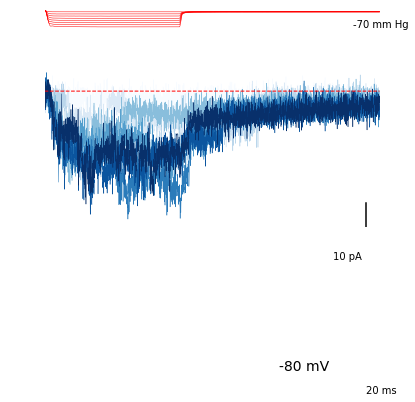

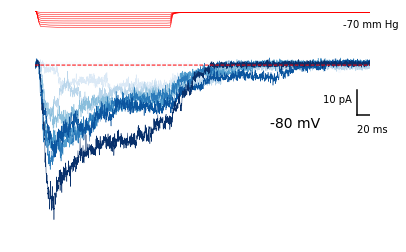

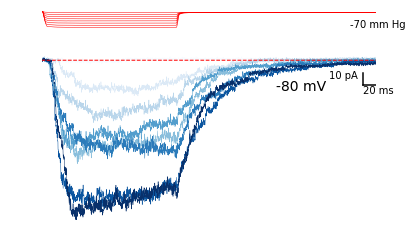

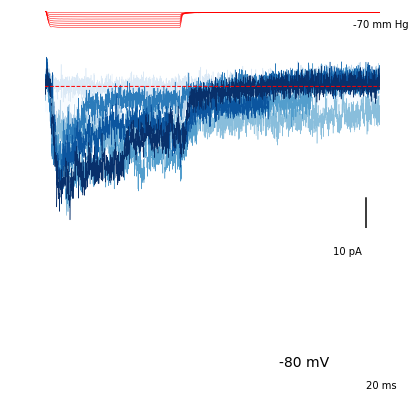

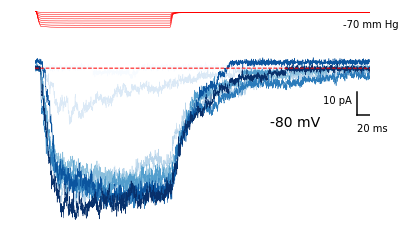

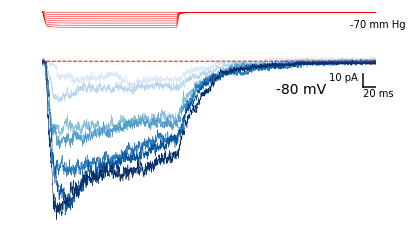

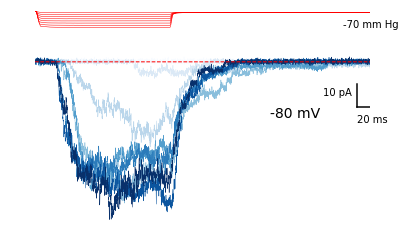

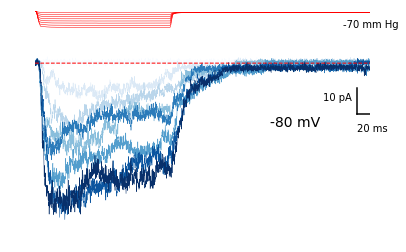

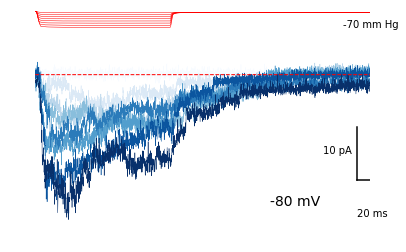

In [4]:
#Loops over all files in a folder:
#Reads file, slices sweep to only show area of interest, shows a plot of the trace for each sweep within that slice
for i in file_list:
    sweep_df =  pd.read_csv(i,sep=",",header=None,
                            names=['index','t1','i','t2','p','t3','v'])

    #convert to pA and ms
    sweep_df.loc[:,'i'] *= 10**12
    sweep_df.loc[:,'t1'] *= 1000
    
    #define the part of the sweep to show (slice) and split the data into its composite sweeps
    sweep_number=8
    sweep_split = np.array_split(sweep_df, sweep_number)
    
    #baseline subtract based on mean between t=1000 ms and t=4900 ms
    for j in range(len(sweep_split)):
        sweep_split[j].loc[:,'i'] -=np.mean(sweep_split[j].i[(sweep_split[j].t1>=1000) & (sweep_split[j].t1<=4500)])
    
    #triaging 
    #sweep_6 = sweep_split[6]
    #if float(min(sweep_6.t1[sweep_6.i==min(sweep_6.i)])) >= 5050:
        #print(i+" failed delay")
        #trace_colour='r-'
    #elif min(sweep_6.i) > -15:
        #print(i+" failed min current")
        #trace_colour='r-'
    #elif float(sweep_6.i[(sweep_6.t1 == 5200)]) < 0.9 * min(sweep_6.i):
        #print(i+" failed inactivation")
        #trace_colour='r-'
    #else:
        #trace_colour='b-'
        #next
        
    #If you would like to see the whole trace set whole_trace to TRUE
    whole_trace = False
    if whole_trace == True:
        plot_start = 0
    else:
        plot_start = 5000
    
    fig,axarr = plt.subplots(2, sharex=True)
    
    colors = plt.cm.Blues(np.linspace(0,1,sweep_number))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10])
    axarr[0]=plt.subplot(gs[0])
    for j in range(len(sweep_split)):
        axarr[0].plot(sweep_split[j].t1,sweep_split[j].p,'r',linewidth=0.5)
    axarr[1]=plt.subplot(gs[1])
    for j in range(len(sweep_split)):
        axarr[1].plot(sweep_split[j].t1,sweep_split[j].i,color=colors[j],linewidth=0.5)
    
    axarr[0].axis('off')
    axarr[1].axis('off')
    
    lh = mlines.Line2D([max(sweep_split[7].t1)-20,max(sweep_split[7].t1)], 
                      [-20,-20],color='black')
    lv = mlines.Line2D([max(sweep_split[7].t1)-20,max(sweep_split[7].t1)-20], 
                      [-10,-20],color='black')
    axarr[1].text(max(sweep_split[7].t1)-70, -15, '10 pA', fontsize=10)
    axarr[1].text(max(sweep_split[7].t1)-20, -27, '20 ms', fontsize=10)
    axarr[0].text(max(sweep_split[7].t1)-40, min(sweep_split[7].p), '-70 mm Hg', fontsize=10)
    axarr[1].text(max(sweep_split[7].t1)-150, -25, '-80 mV', fontsize=14)
    axarr[1].set_xlim(plot_start,max(sweep_split[0].t1))    
    axarr[0].set_xlim(plot_start,max(sweep_split[0].t1))
    axarr[1].plot(sweep_split[0].t1,np.repeat(0,len(sweep_split[0].t1)),'r--',linewidth=1)
    
    axarr[1].add_line(lh)
    axarr[1].add_line(lv)

    plt.show()
    fig.savefig(i[:-4]+'_rep_trace.jpg', facecolor="white")

# Indentation Step Protocol

## Representative Trace

The below code will create a plot of the representative traces aligned to the stimulus trace. The traces are baseline subtracted based on the mean current over the course of the first 100 ms prior to stimulus onset. The red dotted line in the trace indicates 0 pA.

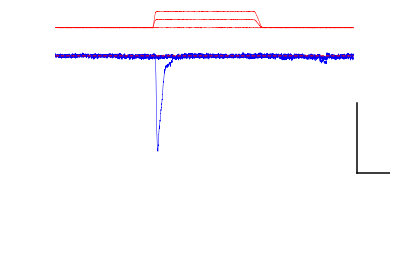

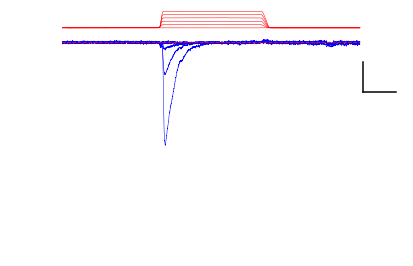

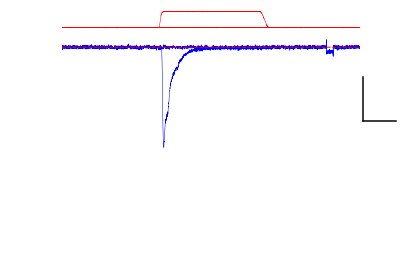

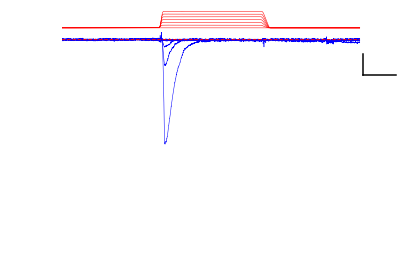

In [12]:
for ii in file_list:
    filename = ii #type file to be analyzed here
    sweep_df = pd.read_csv(filename,sep = ',',header=None, names = ['index','t1','i','t2','poke'])
    
    sweep_df.loc[:,'i'] *= 10**12
    sweep_df.loc[:,'t1'] *= 1000
    sweep_df.loc[:,'poke'] *= 10
    
    #samples per sweep
    samples = 11125
    nsweeps = int(len(sweep_df)/samples)
    sweep_split = np.array_split(sweep_df,nsweeps)

    if np.mean(sweep_split[nsweeps-1].i[sweep_split[nsweeps-1].t1 >= 400]) <= -800 :
        sweep_split = sweep_split[0:nsweeps-1]
        nsweeps -= 1
    else:
        next

    #remove pokes before visible contact
    contact = 1
    sweep_split = sweep_split[contact-1:nsweeps]
    nsweeps = len(sweep_split)
    
    #undo auto poke leak subtract
    #baseline subtract
    for k in range(nsweeps):
        sweep_split[k].poke -= np.mean(sweep_split[k].poke[(sweep_split[k].t1 <= 100)]) 
        sweep_split[k].i -= np.mean(sweep_split[k].i[(sweep_split[k].t1 <= 100)])
    
    #scale bar
    xscale = list(range(450,500))
    yscale = list(range(-500,-200))

    fig = plt.figure(); ax1 = fig.add_subplot(10,1,1); ax2 = fig.add_subplot(10,1,(2,10))
    plt.ylabel('I (pA)')
    plt.xlabel('Time (ms)')
    ax1.axis('off')
    ax1.set_xlim(0,500)
    ax2.set_xlim(0,500)
    ax2.set_ylim(1.8*min(sweep_split[nsweeps-1].i[(sweep_split[nsweeps-1].t1 > 150) & (sweep_split[nsweeps-1].t1 < 300)]),100)
    ax2.axis('off')
    for i in range(nsweeps):
        ax1.plot(sweep_split[i].t1,sweep_split[i].poke, 'r-',linewidth = 0.5)
    for j in range(nsweeps):
        ax2.plot(sweep_split[j].t1, sweep_split[j].i, 'b-', linewidth = 0.5)
    ax2.plot([min(xscale)]*len(yscale),yscale,'k-')
    ax2.plot(xscale,[min(yscale)]*len(xscale),'k-')
    ax2.plot(sweep_split[0].t1,np.repeat(0,len(sweep_split[0].t1)),'r--',linewidth=1)
    plt.show()

    peak_i = []
    poke_step = []
    #for ii in range(nsweeps):
        #peak_i.append(min(sweep_split[ii].i[(sweep_split[ii].t1 > 150) & (sweep_split[ii].t1 < 300)]))
        #poke_step.append(np.mean(sweep_split[ii].poke[(sweep_split[ii].t1 > 200) & (sweep_split[ii].t1 < 250)]))
    
    #poke_curve = pd.DataFrame({'cell_id':filename,
                               #'distance':poke_step,
                               #'peak_i':peak_i})

    #normalize to point of contact
    #poke_curve.distance = poke_curve.distance-min(poke_curve.distance)

    #fig2 = plt.figure()
    #plt.plot(poke_curve.distance,poke_curve.peak_i)
    #plt.xlabel('Distance (microns)')
    #plt.ylabel('I (pA)')

    fig.savefig(filename[:-4]+'rep_trace.jpg',facecolor='white')
    #fig2.savefig(filename[:-4]+'poke_curve.jpg',facecolor='white')
    #poke_curve.to_csv(filename[:-4]+'poke_curve.csv')


## Inactivation Tau 

Fit a single exponential to the trace from the time at which the current is 95% of the peak amplitude (following the peak) until the 300 ms timepoint. Fit is performed on the last complete step of each protocol and is overlayed on the raw current being fit. Currents are leak subtracted. Inactivation taus from each file are appended to a list variable inact_tau_list and can be used for further analysis.

C:\Users\mny3\anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


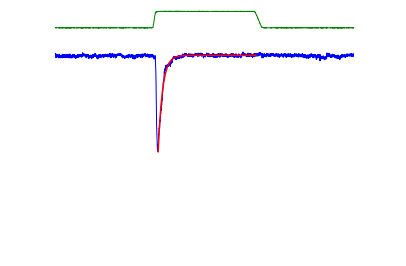

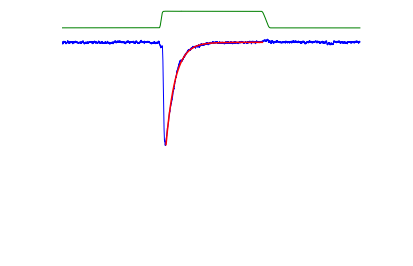

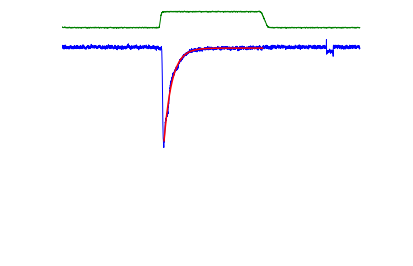

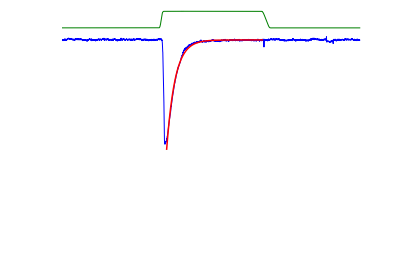

[6.56940020071559, 13.726626482843379, 11.786722410673685, 12.475914074210781]


In [13]:
#load some modules necessary for curve-fitting analysis
from scipy.optimize import curve_fit
from scipy.optimize import minimize, fmin, leastsq

#Define function to be used to fit traces as well as some initial parameter estimates in the variable guess
def single_exp(t, a1, tau1, c):
    return -a1 * np.exp((-1/tau1) * t) + c

guess = (2000, 2, -30)
inact_tau_list=[]

for ii in file_list:
    filename = ii #type file to be analyzed here
    sweep_df = pd.read_csv(filename,sep = ',',header=None, names = ['index','t1','i','t2','poke'])
    
    sweep_df.loc[:,'i'] *= 10**12
    sweep_df.loc[:,'t1'] *= 1000
    sweep_df.loc[:,'poke'] *= 10
    
    #samples per sweep
    samples = 11125
    nsweeps = int(len(sweep_df)/samples)
    sweep_split = np.array_split(sweep_df,nsweeps)

    if np.mean(sweep_split[nsweeps-1].i[sweep_split[nsweeps-1].t1 >= 400]) <= -800 :
        sweep_split = sweep_split[0:nsweeps-1]
        nsweeps -= 1
    else:
        next
        
    last_sweep = sweep_split[nsweeps-1]
    
    #undo auto poke leak subtract
    #baseline subtract
    last_sweep.poke -= np.mean(last_sweep.poke[(last_sweep.t1 <= 100)]) 
    last_sweep.i -= np.mean(last_sweep.i[(last_sweep.t1 <= 100)])
    
    peak_time = last_sweep.t1[last_sweep.i == min(last_sweep.i)]
    resp_region = last_sweep[(last_sweep.i >= 0.95 * min(last_sweep.i)) & (last_sweep.t1 <= 300)]
    decay_region = resp_region[resp_region.t1 > float(peak_time)]
    offset = min(decay_region.t1)
    decay_region.t1 -= offset
    
    try:
        popt, pcov = curve_fit(single_exp, decay_region.t1, decay_region.i, guess, maxfev=10000)
    except RuntimeError:
        print("Error - curve_fit failed")
    inact_tau_list.append(popt[1])
    
    xfine = np.linspace(0., int(max(decay_region.t1)), int(max(decay_region.t1)))
    decay_region.t1 += offset

    fig = plt.figure(); ax1 = fig.add_subplot(10,1,1); ax2 = fig.add_subplot(10,1,(2,10))
    plt.ylabel('I (pA)')
    plt.xlabel('Time (ms)')
    ax1.axis('off')
    ax1.set_xlim(0,500)
    ax2.set_xlim(0,500)
    ax2.set_ylim(1.8*min(last_sweep.i[(last_sweep.t1 > 150) & (last_sweep.t1 < 300)]),100)
    ax1.plot(last_sweep.t1,last_sweep.poke, 'g-',linewidth = 1)
    ax2.axis('off')
    ax2.plot(last_sweep.t1, last_sweep.i, 'b-', linewidth = 1)
    ax2.plot(xfine+min(decay_region.t1), single_exp(xfine, *popt), 'r-')
    plt.show()
    
print(inact_tau_list)

# Combine all CSV Files in folder

The following code takes all individual csv files in a folder and aggregates them into a single spreadsheet that can then be analyzed.

In [ ]:
import shutil
import glob

#import csv files from folder
path = r'C:/Users/mny3/Desktop/whasil'
allFiles = glob.glob(path + "/*.csv")
with open('chondrocyte_agg.csv', 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if i != 0:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")